# SVM with HOG Image Predictor


## 1. Import Required Libraries

In [19]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.svm import SVC

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration - Set Your Paths

Update these paths to match your setup:
- `RESULTS_PATH`: Folder where model is saved
- `model_filepath`: Path to the saved SVM model file

In [20]:
RESULTS_PATH = '/home/ubuntu/Desktop/AIML project/results/SVMhog'
model_filename = 'tuned_svm_model_hog_48x48.joblib'
model_filepath = os.path.join(RESULTS_PATH, model_filename)

# Image specifications (must match training setup)
IMG_HEIGHT = 48
IMG_WIDTH = 48

# HOG parameters using cv2.HOGDescriptor (MUST match generate_hog_features.ipynb)
HOG_PARAMS_CV2 = {
    'winSize': (48, 48),
    'blockSize': (16, 16),
    'blockStride': (8, 8),
    'cellSize': (8, 8),
    'nbins': 9
}

print(f"Model path: {model_filepath}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH} grayscale")
print(f"HOG params (cv2.HOGDescriptor):")
print(f"  - Window: {HOG_PARAMS_CV2['winSize']}")
print(f"  - Block: {HOG_PARAMS_CV2['blockSize']}")
print(f"  - Cell: {HOG_PARAMS_CV2['cellSize']}")
print(f"  - Bins: {HOG_PARAMS_CV2['nbins']}")

# Verify paths exist
if os.path.exists(model_filepath):
    print(" Model file found!")
else:
    print(" Model file not found! Please check the path.")


Model path: /home/ubuntu/Desktop/AIML project/results/SVMhog/tuned_svm_model_hog_48x48.joblib
Image size: 48x48 grayscale
HOG params (cv2.HOGDescriptor):
  - Window: (48, 48)
  - Block: (16, 16)
  - Cell: (8, 8)
  - Bins: 9
 Model file found!


## 4. Load Trained SVM Model

In [21]:
# Load the trained SVM model
try:
    svm_model = joblib.load(model_filepath)
    print(f" Model loaded successfully from: {model_filepath}")
    print(f" Model type: {type(svm_model).__name__}")
    print(f" Kernel: {svm_model.kernel}")
    print(f" C parameter: {svm_model.C}")
    print(f" Gamma: {svm_model.gamma}")
    print(f" Expected feature dimension: {svm_model.n_features_in_}")
    print(f"\n Model ready for predictions!")
except Exception as e:
    print(f" Error loading model: {str(e)}")
    print(f"Please check that the model file exists at: {model_filepath}")

 Model loaded successfully from: /home/ubuntu/Desktop/AIML project/results/SVMhog/tuned_svm_model_hog_48x48.joblib
 Model type: SVC
 Kernel: rbf
 C parameter: 10
 Gamma: scale
 Expected feature dimension: 900

 Model ready for predictions!


## 5. Image Preprocessing and HOG Feature Extraction

In [22]:
def load_and_preprocess_image(image_path):

    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"❌ Error: Unable to load image from {image_path}")
        return None, None
    
    # Resize to 48x48
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    return img, img_resized

def extract_hog_features(image):
    # Initialize HOG descriptor with EXACT parameters from training
    hog = cv2.HOGDescriptor(
        _winSize=(48, 48),      # Image size
        _blockSize=(16, 16),    # Block size
        _blockStride=(8, 8),    # Step size for blocks
        _cellSize=(8, 8),       # Cell size
        _nbins=9                # Number of orientation bins
    )
    
    # Compute HOG features
    features = hog.compute(image)
    
    if features is not None:
        return features.flatten()
    else:
        raise ValueError("Failed to extract HOG features")

print(" Image preprocessing and HOG extraction functions defined")

 Image preprocessing and HOG extraction functions defined


## 6. Prediction Function with Visualization

In [23]:
def predict_image_with_details(image_path, show_top_k=5, show_full_details=False):
    # Check if image exists
    if not os.path.exists(image_path):
        print(f" Image not found: {image_path}")
        return
    
    # Load and preprocess image
    original_img, resized_img = load_and_preprocess_image(image_path)
    
    if original_img is None:
        return
    
    # Extract HOG features
    hog_features = extract_hog_features(resized_img)
    
    # Reshape for prediction (models expect 2D array)
    features_reshaped = hog_features.reshape(1, -1)
    
    # Get prediction
    predicted_class = svm_model.predict(features_reshaped)[0]
    
    # Get decision function values (confidence scores)
    decision_values = svm_model.decision_function(features_reshaped)[0]
    
    # Get all classes the model was trained on
    all_classes = svm_model.classes_
    
    # Convert predicted class to character
    predicted_char = chr(predicted_class) if 32 <= predicted_class <= 126 else str(predicted_class)
    
    # Get top K predictions based on decision function values
    top_k_indices = np.argsort(decision_values)[-show_top_k:][::-1]
    top_k_classes = all_classes[top_k_indices]
    top_k_scores = decision_values[top_k_indices]
    
    # Normalize scores to percentages (softmax-like)
    exp_scores = np.exp(top_k_scores - np.max(top_k_scores))  # Subtract max for numerical stability
    top_k_percentages = (exp_scores / np.sum(exp_scores)) * 100
    
    # Convert top K classes to characters
    top_k_chars = [chr(cls) if 32 <= cls <= 126 else str(cls) for cls in top_k_classes]
    
    # Visualization
    fig = plt.figure(figsize=(16, 5))
    
    # 1. Original image
    ax1 = plt.subplot(1, 4, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Original Image\n{original_img.shape[1]}x{original_img.shape[0]}', 
              fontsize=11, fontweight='bold')
    plt.axis('off')
    
    # 2. Resized image
    ax2 = plt.subplot(1, 4, 2)
    plt.imshow(resized_img, cmap='gray')
    plt.title(f'Preprocessed\n{IMG_HEIGHT}x{IMG_WIDTH} Grayscale', 
              fontsize=11, fontweight='bold')
    plt.axis('off')
    
    # 3. HOG visualization (using skimage for visualization only)
    ax3 = plt.subplot(1, 4, 3)
    from skimage.feature import hog as skimage_hog
    # Note: This is just for visualization - the actual features use cv2.HOGDescriptor
    hog_features_viz, hog_image = skimage_hog(
        resized_img, 
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True
    )
    plt.imshow(hog_image, cmap='gray')
    plt.title(f'HOG Features\n{len(hog_features)} dimensions', 
              fontsize=11, fontweight='bold')
    plt.axis('off')
    
    # 4. Top predictions bar chart
    ax4 = plt.subplot(1, 4, 4)
    labels_to_plot = [f"{char}\n({cls})" for char, cls in zip(top_k_chars, top_k_classes)]
    colors = ['green' if i == 0 else 'lightblue' for i in range(len(labels_to_plot))]
    
    bars = plt.barh(range(len(labels_to_plot)), top_k_percentages, color=colors, alpha=0.8)
    plt.yticks(range(len(labels_to_plot)), labels_to_plot, fontsize=9)
    plt.xlabel('Confidence (%)', fontsize=10)
    plt.title(f'Top {show_top_k} Predictions', fontsize=11, fontweight='bold')
    plt.xlim(0, 100)
    plt.gca().invert_yaxis()
    
    # Add percentage labels on bars
    for i, pct in enumerate(top_k_percentages):
        plt.text(pct + 1, i, f'{pct:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print prediction summary - Simple version (only percentages)
    if not show_full_details:
        print("\n" + "="*80)
        print(" PREDICTION RESULT")
        print("="*80)
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Predicted Character: '{predicted_char}'")
        print(f"Confidence: {top_k_percentages[0]:.1f}%")
        print("-" * 80)
        print(f" Top {show_top_k} Predictions (Percentage):")
        for i, (char, cls, pct) in enumerate(zip(top_k_chars, top_k_classes, top_k_percentages), 1):
            print(f"  {i}. '{char}' (class: {cls}): {pct:.1f}%")
        print("="*80)
    else:
        # Print full details version
        print("\n" + "="*80)
        print(" PREDICTION RESULT")
        print("="*80)
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Original Size: {original_img.shape[1]}x{original_img.shape[0]}")
        print(f"Preprocessed Size: {IMG_HEIGHT}x{IMG_WIDTH}")
        print(f"HOG Feature Dimension: {len(hog_features)}")
        print("-" * 80)
        print(f"Predicted Character: '{predicted_char}'")
        print(f"Predicted Class (ASCII): {predicted_class}")
        print(f"Confidence: {top_k_percentages[0]:.1f}%")
        print("="*80)
        
        print(f"\n Top {show_top_k} Predictions (with Decision Scores):")
        for i, (char, cls, score, pct) in enumerate(zip(top_k_chars, top_k_classes, top_k_scores, top_k_percentages), 1):
            print(f"  {i}. '{char}' (class: {cls}) - Score: {score:.4f}, Confidence: {pct:.1f}%")
        print("="*80)

print("✓ Prediction function defined")

✓ Prediction function defined


## 7. Predict Single Custom Image

**Change the image path below to predict your own image!**

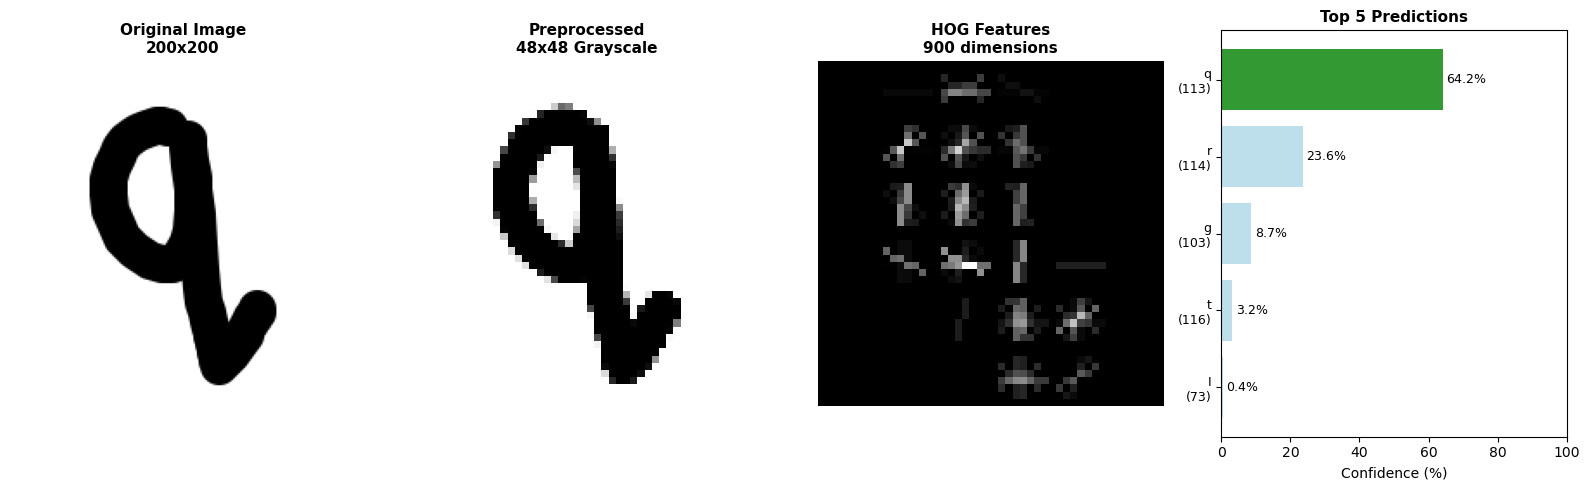


 PREDICTION RESULT
Image: asaad.png
Predicted Character: 'q'
Confidence: 64.2%
--------------------------------------------------------------------------------
 Top 5 Predictions (Percentage):
  1. 'q' (class: 113): 64.2%
  2. 'r' (class: 114): 23.6%
  3. 'g' (class: 103): 8.7%
  4. 't' (class: 116): 3.2%
  5. 'I' (class: 73): 0.4%


In [24]:
# CHANGE THIS PATH TO YOUR IMAGE
custom_image_path = '/home/ubuntu/Pictures/asaad.png'

# Run prediction with simple output (only percentages)
predict_image_with_details(custom_image_path, show_top_k=5, show_full_details=False)

# If you want to see full details with decision scores, use:
# predict_image_with_details(custom_image_path, show_top_k=5, show_full_details=True)